> For further description, please refer to Training.ipynb file.

## Topics:
1. Imports
2. Getting dataset ready
    1. Merge Train and Test dataset
    2. Cleansing Dataset
    3. Handle Missing Values
3. Feature Engineering
4. Modeling and Predicting
    1. Train and Test data seperation
    2. Load the Model
    3. Predicting output of Test data

---

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import re
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, cross_validate, KFold, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import plot_importance

%matplotlib inline

***

## 2. Getting dataset ready

> You can access test data from [here](https://drive.google.com/open?id=1C1eDzYSWy5vyhD--4Dn8tS_ev-wpUrOp)

In [2]:
# Read train and test dataset
df_train = pd.read_csv('data.csv')
df_test = pd.read_csv('test.csv')

In [3]:
print(df_train.shape)
print(df_test.shape)

(616656, 20)
(154165, 19)


In [4]:
# Keep last index of training dataset
last_index = df_train.shape[0]

In [5]:
# Add new column for test dataset
df_test['Market Share_total'] = 0.0

#### A. Merge Train and Test dataset

In [6]:
# Merge train and test dataset into one dataframe
pieces = {'train': df_train, 'test': df_test}
df = pd.concat(pieces, sort=False, ignore_index=True)

In [7]:
df[last_index-1:last_index+2]

,Unnamed: 0,Episode,Station,Channel Type,Season,Year,Date,Day of week,Start_time,End_time,Length,Name of show,Name of episode,Genre,First time or rerun,# of episode in the season,Movie?,Game of the Canadiens during episode?,Market Share_total,Temperature in Montreal during episode
616655,616656,Mom V.F. (M),VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,2019-01-22 11:00:00,2019-01-22 11:30:00,2,Mom V.F. (M),Les bons samaritains,Ongoing Comedy Series (Sitcoms),No,Yes,No,No,1.6,-22.525
616656,1,Mom V.F. (M),VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,2019-01-22 11:30:00,2019-01-22 12:00:00,2,Mom V.F. (M),Abstinence,Ongoing Comedy Series (Sitcoms),No,Yes,No,No,0.0,-22.525
616657,2,2 filles fauchées,VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,2019-01-22 12:00:00,2019-01-22 12:30:00,2,2 filles fauchées,Et la rupture,Ongoing Comedy Series (Sitcoms),No,Yes,No,No,0.0,-21.625


#### B. Cleansing Dataset

In [8]:
# Rename some column names for convinience
df.rename(columns = {"Market Share_total": "Target", 
                     "Temperature in Montreal during episode": "Temperature",
                     "Game of the Canadiens during episode?": "Any game?", 
                     "First time or rerun": "First time?",
                     "# of episode in the season": "Episodes?"},
         inplace=True)

In [9]:
# Change Date column to datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Create new columns: "Month" and "Day" from "Date" Column
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month

# Extract time from "Start_time"
df['Start_time'] = pd.to_datetime(df['Start_time']).dt.time

# Extract time from "End_time"
df['End_time'] = pd.to_datetime(df['End_time']).dt.time

#### C. Handle Missing Values

In [10]:
df.isnull().sum()

Unnamed: 0              0
Episode                 0
Station                 0
Channel Type            0
Season                  0
Year                    0
Date                    0
Day of week             0
Start_time             65
End_time               65
Length                  0
Name of show            0
Name of episode    253198
Genre                   0
First time?             0
Episodes?               0
Movie?                  0
Any game?               0
Target                  0
Temperature        106573
Day                     0
Month                   0
dtype: int64

In [11]:
# Remove Name of episode Column
df.drop('Name of episode', axis=1, inplace=True)

In [12]:
# Subtitude missing values of Start_time with some dummy number 
indices = df[df['Start_time'].isnull()]['Start_time'].index
for i in indices:
    df.at[i, ['Start_time']] = dt.datetime.strptime('03:00:00', '%H:%M:%S').time()

In [13]:
indices = df[df['End_time'].isnull()]['End_time'].index
for i in indices:
    df.at[i, ['End_time']] = dt.datetime.strptime('03:00:00', '%H:%M:%S').time()

In [14]:
# Subtitude missing temperature values with average temperature among differnt months
indices = df[df['Temperature'].isnull()]['Month'].index
months = df[df['Temperature'].isnull()]['Month'].values
mean_temps = df['Temperature'].groupby(df['Month']).mean()

for i,month in enumerate(months):
    df.at[indices[i], 'Temperature'] = mean_temps[month]

In [15]:
df.isnull().sum()

Unnamed: 0      0
Episode         0
Station         0
Channel Type    0
Season          0
Year            0
Date            0
Day of week     0
Start_time      0
End_time        0
Length          0
Name of show    0
Genre           0
First time?     0
Episodes?       0
Movie?          0
Any game?       0
Target          0
Temperature     0
Day             0
Month           0
dtype: int64

---

## 3. Feature Engineering

In [16]:
# Binning Temperature column into some Interval
temp = df['Temperature']
bw = int( (max(temp) - min(temp)) / 5 )
bins = range(int(min(temp)), int(max(temp)), bw)
df['Temp-binned'] = pd.cut(temp, bins)

# Binning Length column into some Interval
leng = df['Length']
bw = int( (max(leng) - min(leng)) / 5 )
bins = range(int(min(leng)), int(max(leng)), bw)
df['Length-binned'] = pd.cut(leng, bins)

In [17]:
# Seperate weekday or weekend values in a different column
df['Weekend?'] = ['Yes' if (row == 'Sunday' or row == 'Saturday') else 'No' 
                  for row in df['Day of week']]

In [18]:
df['Time of start'] = ['Morning' if (row >= dt.time(6) and row < dt.time(12)) 
                       else 'Afternoon' if (row >= dt.time(12) and row < dt.time(16))
                       else 'Evening' if (row >= dt.time(16) and row < dt.time(20))
                       else 'Night' if (row >= dt.time(20) and row < dt.time(23,55,0))
                       else 'Midnight'
                       for row in df['Start_time']]

In [19]:
# Calculate and subtitude mean, std and max of Target values of previous shows 
# which have same Name of show for any new sample in training part of dataset

df['avg_prv_target'] = 0.0
df['max_prv_target'] = 0.0
df['std_prv_target'] = 0.0

df_train = df[:last_index]
serials = df_train.groupby(df_train['Name of show']).size().index

for serial in serials:
    inds = df_train[df_train['Name of show'] == serial]['Target'].index
    vals = df_train[df_train['Name of show'] == serial]['Target'].values
    
    for i in range(1,len(inds)):
        df.at[inds[i], 'avg_prv_target'] = round(np.mean(vals[0:i]),2)
        df.at[inds[i], 'max_prv_target'] = round(np.max(vals[0:i]),2)
        df.at[inds[i], 'std_prv_target'] = round(np.std(vals[0:i]),2)

In [20]:
# Subtitude std, max and mean of targets column in test part of dataset with 
# these values from calculated values in training part

df_train = df[:last_index]
df_test = df[last_index:]

train_serials = df_train.groupby(df_train['Name of show']).size().index
test_serials = df_test.groupby(df_test['Name of show']).size().index


for serial in test_serials:
    if serial in train_serials:
        
        a = round(np.mean(df_train[df_train['Name of show'] == serial]['Target']),2)
        m = round(np.max(df_train[df_train['Name of show'] == serial]['Target']),2)
        s = round(np.std(df_train[df_train['Name of show'] == serial]['Target']),2)
        
        inds = df_test[df_test['Name of show'] == serial].index
        for i in inds:
            df.at[i, 'avg_prv_target'] = a
            df.at[i, 'max_prv_target'] = m
            df.at[i, 'std_prv_target'] = s

In [21]:
removing_columns = ['Episode', 'Date', 'Day of week', 'Start_time', 'End_time', 'Length', 
                    'Name of show', 'Target', 'Temperature', 'Day', 'Month']
df_new = df.drop(removing_columns, axis=1)

In [22]:
encoding_columns = ['Station', 'Channel Type', 'Season', 'Year', 'Genre', 'First time?', 
                    'Episodes?', 'Movie?','Any game?', 'Temp-binned', 'Length-binned', 
                    'Weekend?', 'Time of start']
df_new = pd.get_dummies(df_new, columns=encoding_columns)

***

## 4. Modeling and Predicting

#### A. Train and Test data seperation

In [23]:
X = df_new
y = df['Target']

In [24]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) 
             else col for col in X.columns.values]

In [25]:
X.loc[last_index-1:last_index +2]

,Unnamed: 0,avg_prv_target,max_prv_target,std_prv_target,Station_ARTV+,Station_Canal D+,Station_Canal Vie+,Station_Evasion+,Station_Historia+,Station_LCN+,...,"Length-binned_(36, 54_","Length-binned_(54, 72_","Length-binned_(72, 90_",Weekend?_No,Weekend?_Yes,Time of start_Afternoon,Time of start_Evening,Time of start_Midnight,Time of start_Morning,Time of start_Night
616655,616656,0.33,0.9,0.21,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
616656,1,0.39,1.6,0.35,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
616657,2,0.77,3.5,0.60,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
616658,3,0.83,3.9,0.70,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [26]:
X.drop('Unnamed: 0', axis=1, inplace=True)

In [27]:
# Assign each part of dataframe to training and test
X_train = X.loc[:last_index]
X_test = X.loc[last_index:]
y_train = y.loc[:last_index]

#### B. Load the Model

In [28]:
# load saved model
filename = 'xgb_model.sav'
xg_reg = pickle.load(open(filename, 'rb'))

In [29]:
# Fit the model into training set
xg_reg.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=50,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=10,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

#### C. Predicting output of Test data

In [30]:
# predict total market share for test set
y_test = xg_reg.predict(X_test)

Text(0.5, 1.0, 'Y Test')

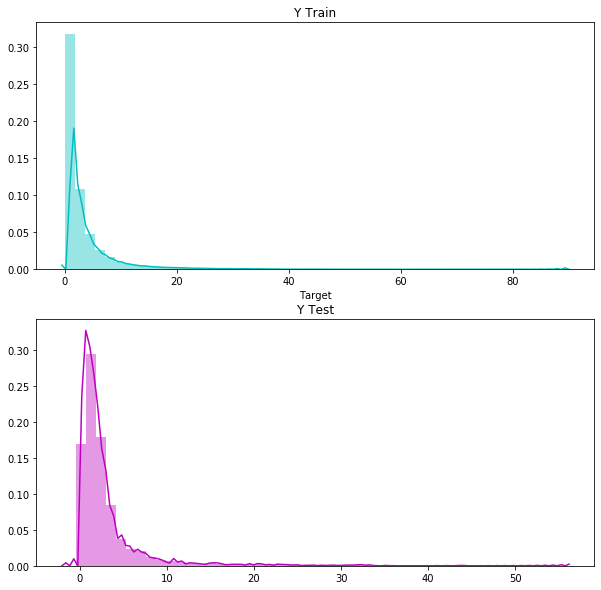

In [31]:
# Comparison between distribution of training and test sets
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

sns.distplot(y_train, color='c', ax=axes[0])
axes[0].set_title('Y Train')

sns.distplot(y_test,  color='m', ax=axes[1])
axes[1].set_title('Y Test')

In [32]:
# Save output into a file
test_data = 'prediction.sav'
pickle.dump(y_test, open(test_data, 'wb'))